In [1]:
import sys
sys.path.append("..")

from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential

import numpy as np
from scipy import stats
from IPython.display import Image, display

import corner

import datetime
import random

import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib import rcParams

import datetime
%matplotlib inline

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['image.cmap'] = 'magma'
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.format'] = 'png'

cmap = copy.copy(plt.cm.get_cmap(rcParams['image.cmap']))
cmap.set_bad((0,0,0))
%config InlineBackend.figure_format = 'retina'


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
machine = 'mac'
#machine = 'magny'
machine = 'virgo'

if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
elif machine == 'virgo': 
    basedir = "/virgo/simulations/Auriga/level4_MHD/"
    filedir = "/u/milas/masterthesis/masterproject/files/"
    plotdir = "/u/milas/masterthesis/masterproject/plots/"
   

In [3]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

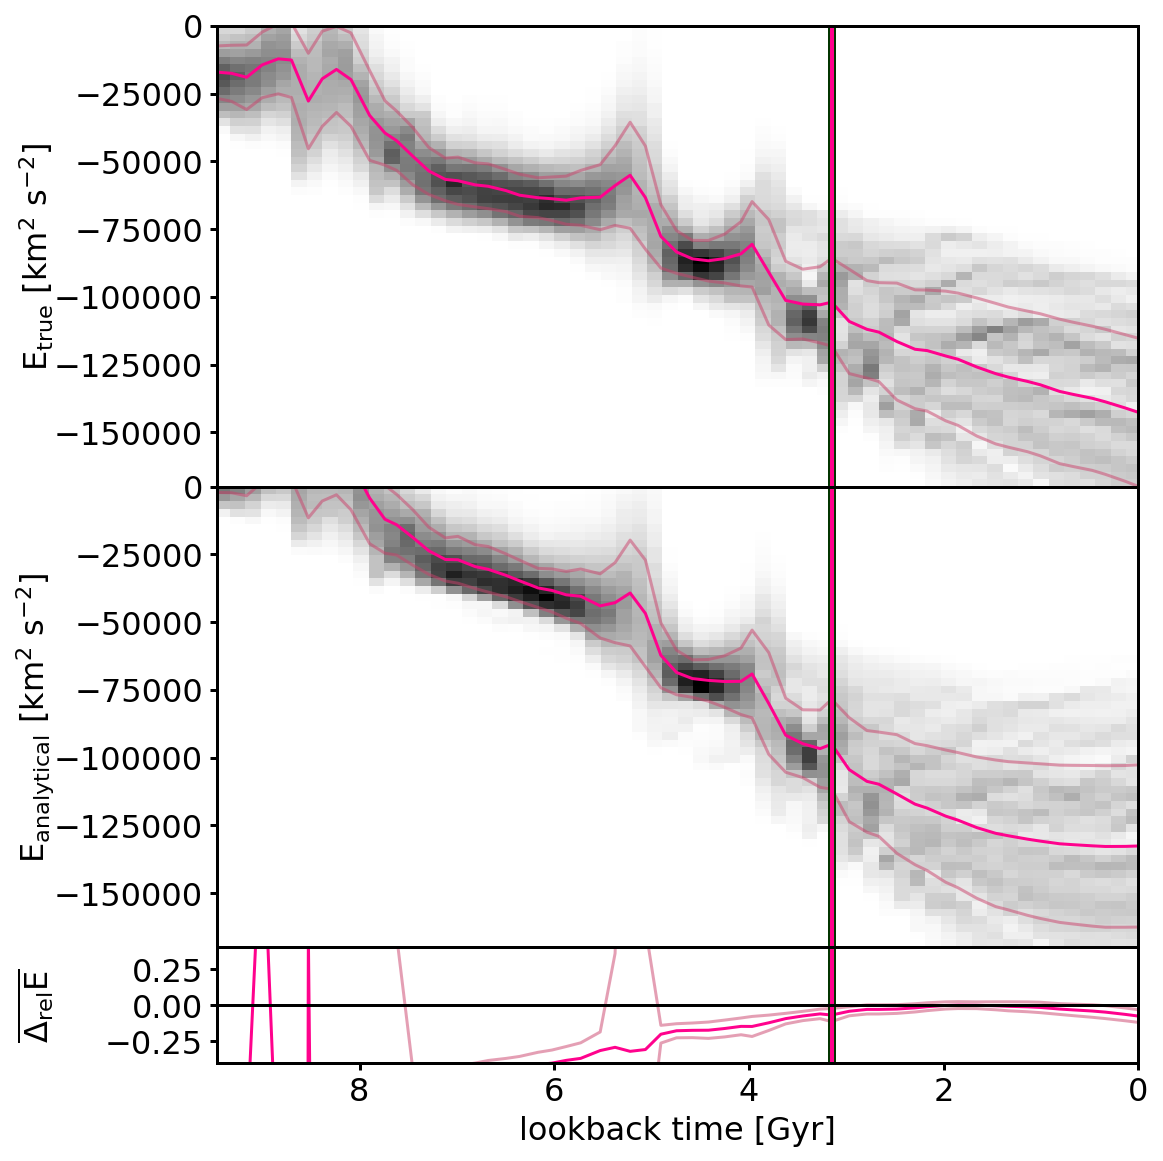

In [4]:
age = np.loadtxt(filedir + 'auriga/survivor_overview_all_snapshots.txt',usecols = 1, skiprows=2)
prognr = 2

#IDs_saved, angmom_arr_kpckms, e_au_km2s2, e_galpy_km2s2 = np.loadtxt(filedir + 'potential/progenitor{}/energy_angmom_gcswodisk_jan19_snap_{}.txt'.format(prognr, snapnr)) 

startnr = 68
endnr = 128
numsnaps = endnr-startnr
lookback_time_Gyr = np.loadtxt(filedir + 'auriga/survivor_overview_all_snapshots.txt',usecols = 1, skiprows=2)[-numsnaps:]

energy_au_mean  = []
energy_gal_mean = []
angmom_mean     = []
energy_au_std   = []
energy_gal_std  = []
angmom_std      = []
energy_au_all   = []
energy_gal_all  = []
angmom_all      = []
tot_error_all   = []
rel_error_all   = []
mean_diff       = []
std_diff        = []
mean_rel        = []
std_rel         = []
hist_x = []
histtime_x = []

for snap_number in range(startnr, endnr, 1):
    ii = snap_number-startnr
    snap_time = lookback_time_Gyr[ii]
    IDs, angmom_arr_kpckms, e_au_km2s2, e_galpy_km2s2 = np.loadtxt(filedir + 'potential/progenitor{}/energy_angmom_gcswodisk_jan19_snap_{}.txt'.format(prognr, snap_number)) 

    energy_au_mean.append(np.mean(e_au_km2s2)) 
    energy_au_std.append(np.std(e_au_km2s2))
    energy_gal_mean.append(np.mean(e_galpy_km2s2)) 
    energy_gal_std.append(np.std(e_galpy_km2s2))
    angmom_mean.append(np.mean(angmom_arr_kpckms)) 
    angmom_std.append(np.std(angmom_arr_kpckms))
    energy_au_all.append(e_au_km2s2)
    energy_gal_all.append(e_galpy_km2s2)
    angmom_all.append(angmom_arr_kpckms)
    hist_x.append(np.full(len(e_galpy_km2s2), snap_number))
    histtime_x.append(np.full(len(e_galpy_km2s2), snap_time))
    mean_diff.append(np.mean(e_galpy_km2s2 - e_au_km2s2))
    std_diff.append(np.std(e_galpy_km2s2 - e_au_km2s2))
    mean_rel.append(np.mean((e_galpy_km2s2 - e_au_km2s2)/e_au_km2s2))
    std_rel.append(np.std((e_galpy_km2s2 - e_au_km2s2)/e_au_km2s2))
    

flat_e_au = [item for sublist in energy_au_all for item in sublist]
flat_e_gal = [item for sublist in energy_gal_all for item in sublist]
flat_angmom = [item for sublist in angmom_all for item in sublist]
flat_e_au = np.array(flat_e_au)
flat_e_gal = np.array(flat_e_gal)
flat_angmom = np.array(flat_angmom)
flat_histx = [item for sublist in hist_x for item in sublist]
flat_histtime = [item for sublist in histtime_x for item in sublist]
flat_histx = np.array(flat_histx)
flat_histtime = np.array(flat_histtime)

xrange = np.unique(flat_histtime)
x = np.arange(len(flat_histtime))
z = np.polyfit(x,flat_histtime, 1)
p = np.poly1d(z)
time = p(x)

mergertime1 = age[-(128-108)]
mergertime2 = age[-(128-73)]
mergertime3 = age[-(128-64)]    

colors = ['black', 'black', 'xkcd:hot pink', 'xkcd:indigo blue', 'xkcd:saffron']
colors2 = ['black', 'black', 'xkcd:pink', 'xkcd:blue', 'xkcd:yellow']
colors2 = ['black', 'black', 'xkcd:dark pink', 'xkcd:dark blue', 'xkcd:dark yellow']

color11 = colors[2]
color12 = 'xkcd:pink'
color13 = 'xkcd:dark pink'
color21 = colors[3]
color22 = 'xkcd:blue'
color23 = 'xkcd:dark blue'
color31 = colors[4]
color32 = 'xkcd:yellow'
color33 = 'xkcd:dark yellow'

agerange = age[-(128-len(energy_au_mean)):]
agerange = lookback_time_Gyr

max_e_au = 0.
min_e_au = -170000.
max_e_gal = 0.
min_e_gal = -170000.
max_LZ = 10000.
min_LZ = -20000.

if prognr == 4:
    max_e_au = 0.
    min_e_au = -170000.
    max_e_gal = 0.
    min_e_gal = -170000.
    max_LZ = 15000.
    min_LZ = -5000.
#fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,12))

# smooth out over hisstime because uneven bins in there mess up hist2d
fig = plt.figure(figsize = (8,8))
ax0 = fig.add_axes([0.15, 0.6, 0.8, 0.4],xticklabels=[])
ax1 = fig.add_axes([0.15, 0.2, 0.8, 0.4],xticklabels=[])  
ax2 = fig.add_axes([0.15, 0.1, 0.8, 0.1],)  


#ax2.get_yaxis().set_label_coords(-0.3,0.5)


bins = numsnaps

color = colors[prognr]
color2 = colors2[prognr]

err_cond = (flat_e_au <max_e_au) * (flat_e_au > min_e_au) * (flat_e_gal <max_e_gal) * (flat_e_gal > min_e_gal)
abs_err = (flat_e_gal - flat_e_au)[err_cond]
rel_err = ((flat_e_gal - flat_e_au)/flat_e_au)[err_cond]

ax0.hist2d(time[(flat_e_au <max_e_au) * (flat_e_au > min_e_au)], flat_e_au[(flat_e_au <max_e_au) * (flat_e_au > min_e_au)], bins = bins , cmap = plt.cm.binary)
ax0.plot(agerange, energy_au_mean, '-',  color = color)
ax0.plot(agerange, np.add(energy_au_mean, energy_au_std), '-', alpha = 0.5,  color = color2)
ax0.plot(agerange, np.subtract(energy_au_mean, energy_au_std), '-', alpha = 0.5, color = color2)
ax0.set_xlim(np.max(flat_histtime), 0)
ax0.get_yaxis().set_label_coords(-0.175,0.5)

#cbar = fig.colorbar(H1[3], ax[0])

ax1.hist2d(time[(flat_e_gal <max_e_gal) * (flat_e_gal > min_e_gal)], flat_e_gal[(flat_e_gal <max_e_gal) * (flat_e_gal > min_e_gal)], bins = bins, cmap = plt.cm.binary)
ax1.plot(agerange, energy_gal_mean, '-',  color = color)
ax1.plot(agerange, np.add(energy_gal_mean, energy_gal_std), '-', alpha = 0.5, color = color2)
ax1.plot(agerange, np.subtract(energy_gal_mean, energy_gal_std), '-', alpha = 0.5, color = color2)
ax1.set_xlim(np.max(flat_histtime), 0)
ax1.get_yaxis().set_label_coords(-0.175,0.5)

#ax2.plot(agerange, std_diff)
#I2 = ax2.hist2d(time[err_cond], rel_err, bins = bins, cmap = cmap)#,norm = LogNorm())#, norm = MidpointNormalize(midpoint = 0.))
#cbar2 = plt.colorbar(I2[3], ax = ax2)
#cbar2.set_label('N$_\mathrm{GCs}$')
ax2.plot(agerange, mean_rel, '-',  color = color)
ax2.plot(agerange, np.add(mean_rel, std_rel), '-', alpha = 0.5,  color = color2)
ax2.plot(agerange, np.subtract(mean_rel, std_rel), '-', alpha = 0.5, color = color2)
ax2.set_xlim(np.max(flat_histtime), 0)
ax2.get_yaxis().set_label_coords(-0.175,0.5)

ax0.axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
ax0.axvline(mergertime1, color = color11, linewidth = 2)
ax1.axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
ax1.axvline(mergertime1, color = color11, linewidth = 2)
ax2.axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
ax2.axvline(mergertime1, color = color11, linewidth = 2)

if prognr == 2:
    pass
else:
    ax0.axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
    ax0.axvline(mergertime2, color = color21, linewidth = 2)
    ax1.axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
    ax1.axvline(mergertime2, color = color21, linewidth = 2)
    ax2.axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
    ax2.axvline(mergertime2, color = color21, linewidth = 2)
    
    if prognr == 3:
        pass
    else:
        ax0.axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
        ax0.axvline(mergertime3, color = color31, linewidth = 2)
        ax1.axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
        ax1.axvline(mergertime3, color = color31, linewidth = 2)
        ax2.axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
        ax2.axvline(mergertime3, color = color31, linewidth = 2)
        #ax[2].set_xlabel('Snapshot number', fontsize = 20)


ax0.set_ylabel('E$_\mathrm{true}$ [km$^2$ s$^{-2}$]')
ax1.set_ylabel('E$_\mathrm{analytical}$ [km$^2$ s$^{-2}$]')
ax2.set_ylabel('$\overline{\Delta_\mathrm{rel}\mathrm{E}}$')

ax2.set_xlabel('lookback time [Gyr]')
ax2.axhline(0, linewidth = 1.5, color = 'k')
ax2.set_ylim(-0.4, 0.40)
#ax2.set_yscale('symlog',linthreshx=1e-3)

#fig.tight_layout()
fig.savefig(plotdir + 'actions/right_potential/progenitor{}/energy_time_evolution_gcwodisk_hist_mean.png'.format(prognr), format = 'png', dpi = 300)
plt.show()

In [5]:
print(np.max(time))

9.49377402768


In [6]:
print(np.max(agerange))

9.46472439035
